# <center> Tarea de clasificación usando MLflow </center>

## 1. Librerías

In [ ]:
import joblib
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import warnings
warnings.filterwarnings("ignore")

## 2. Carga de datos

In [2]:
boston = pd.read_csv('../data/sample/boston.csv', index_col = 0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## 3. Exploración de datos

### 3.1. Cantidad de datos

In [3]:
boston.shape

(506, 13)

### 3.2. Información de datos

In [4]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 1 to 506
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 55.3 KB


### 3.3. Estadísticos descriptivos

In [5]:
boston.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


### 3.4. Distribución y correlación de los datos

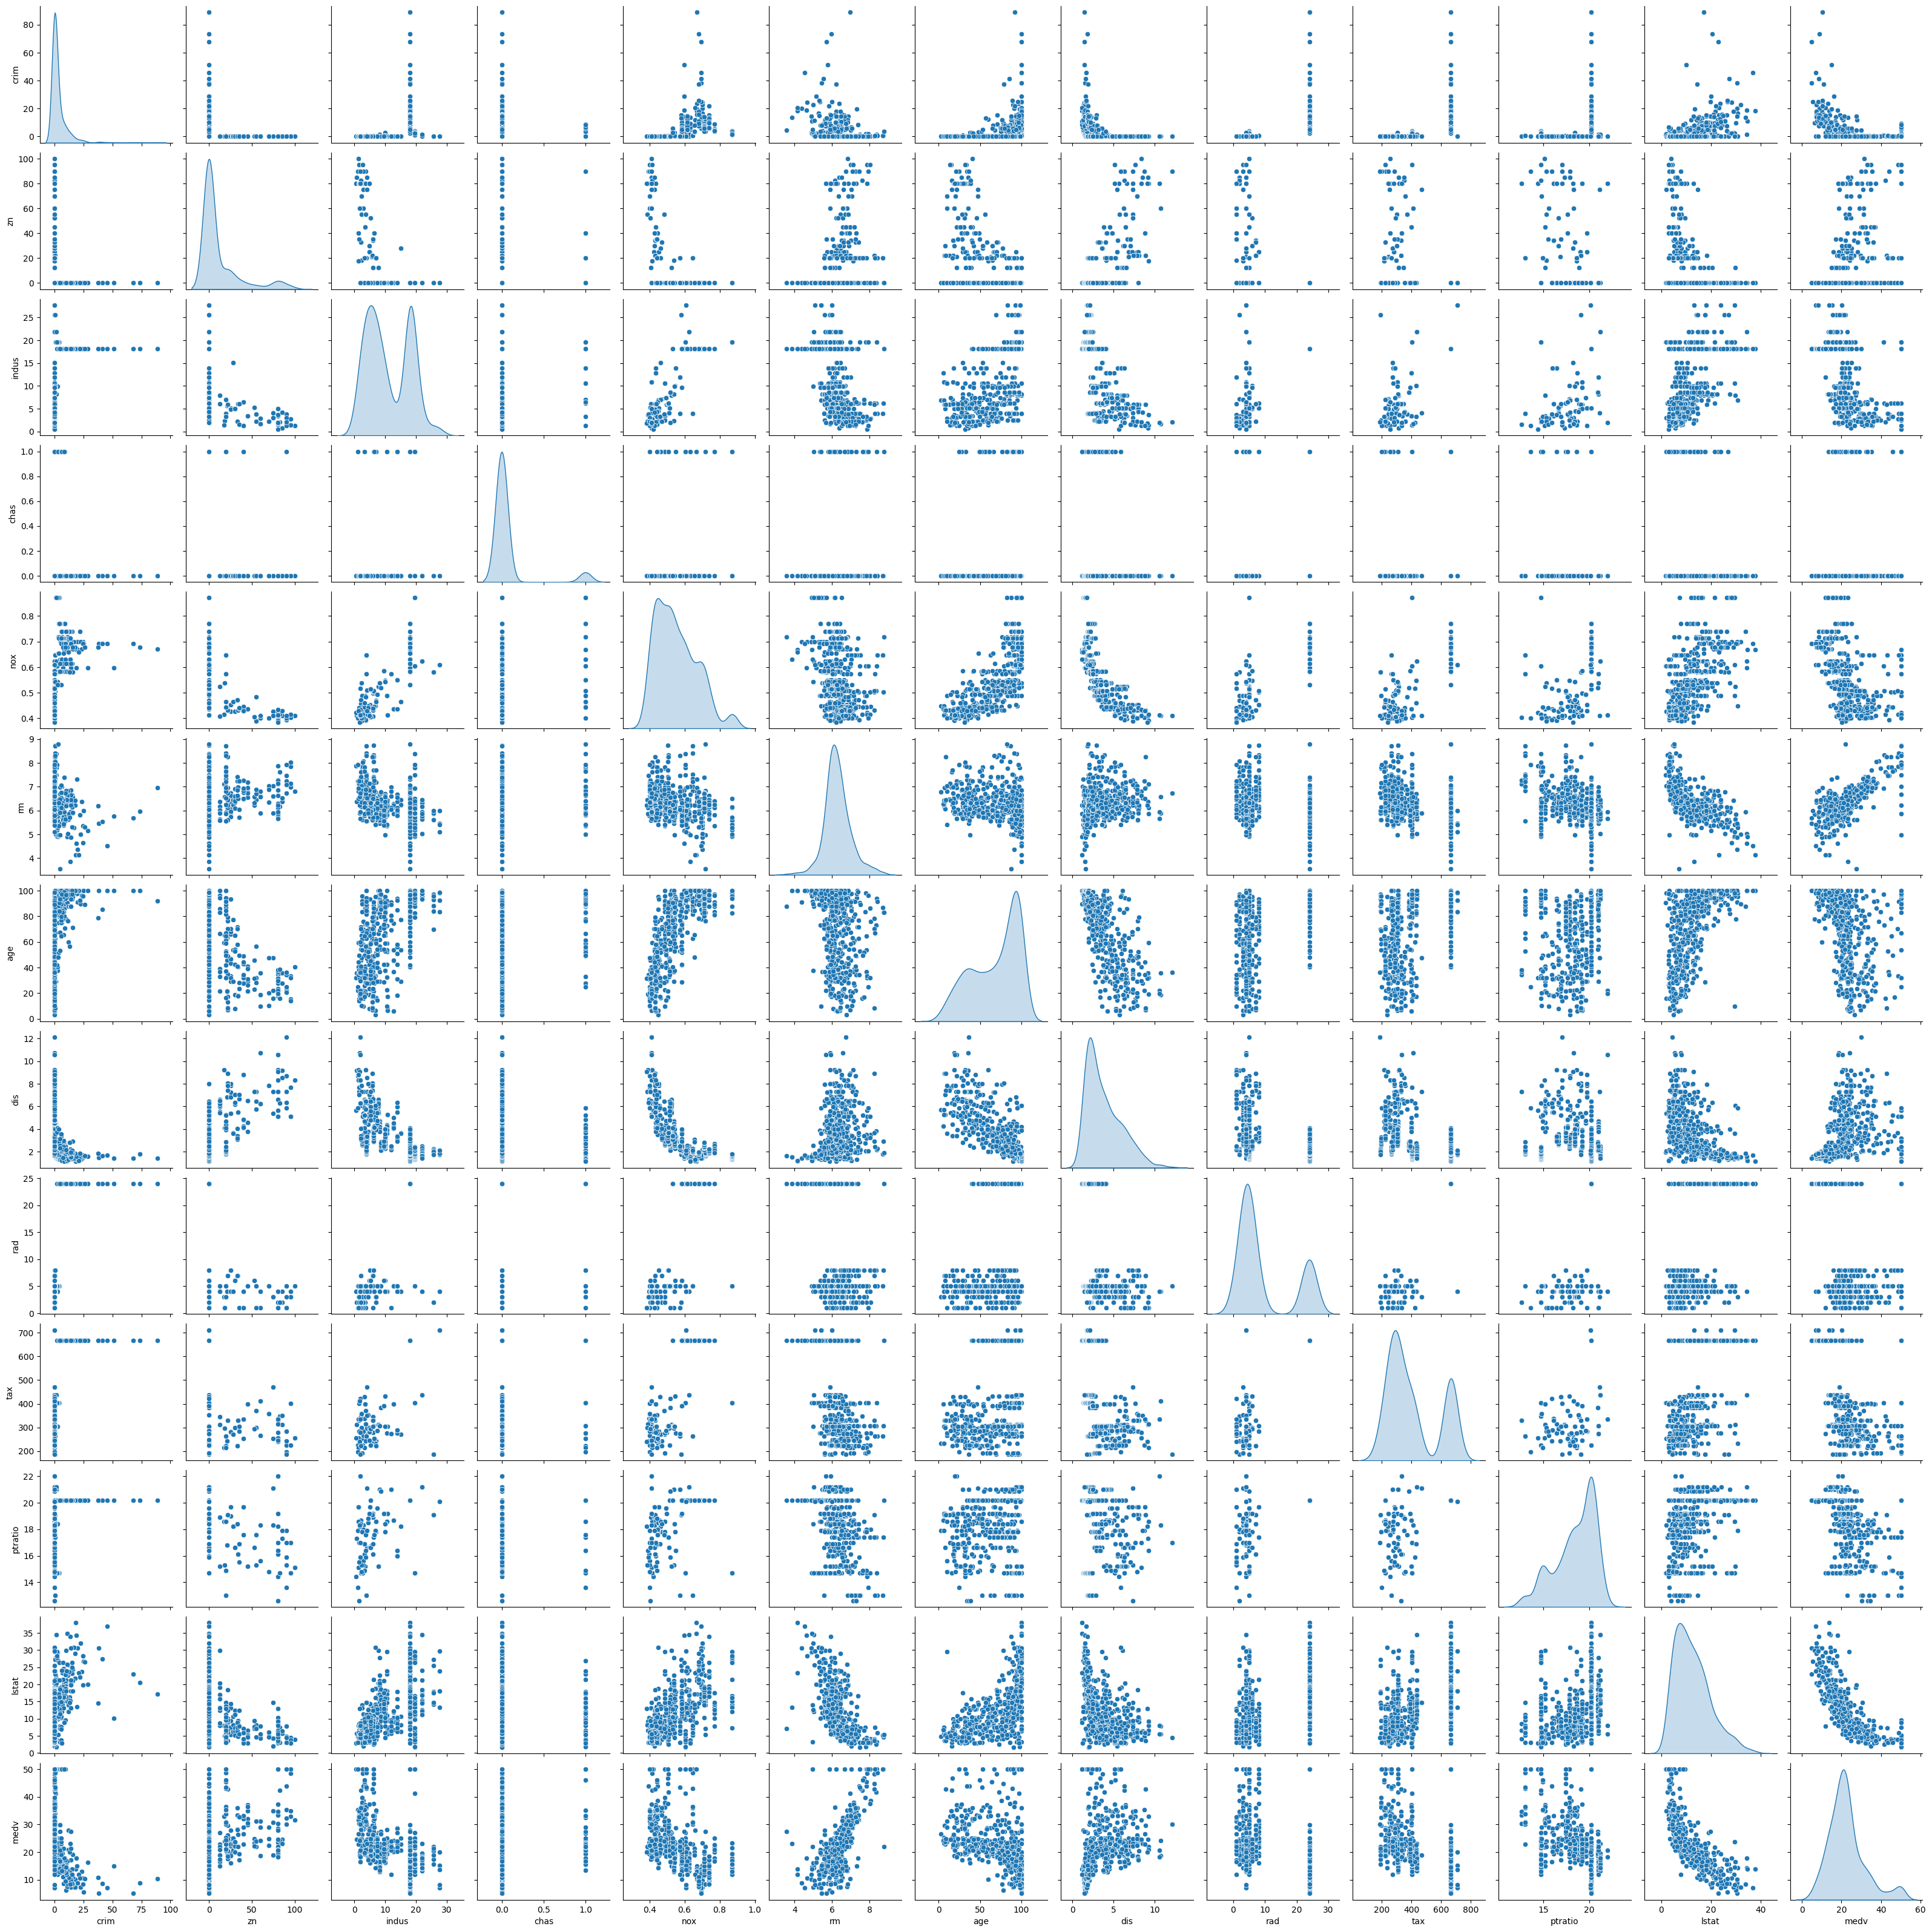

In [6]:
sns.pairplot(boston, diag_kind = "kde")
plt.show()

### 3.5. Creación variable categórica

In [7]:
boston['Y'] = np.where(boston['crim'] > boston['crim'].median(), 1, 0).astype(int)
boston['Y'].value_counts()

Y
0    253
1    253
Name: count, dtype: int64

## 4. División y normalización de datos

In [8]:
X = boston.drop(columns = ['medv'])
y = boston['Y']

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = boston.columns[:-1], index = boston.index)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

## 5. Detección de outliers

In [11]:
envelope = EllipticEnvelope(contamination = 0.05, random_state = 42)
envelope.fit(X_train)

train_mask = envelope.predict(X_train) == 1
X_train_clean, y_train_clean = X_train[train_mask], y_train[train_mask]

## 6. Métricas de los modelos

In [12]:
def get_metrics(y_true, y_pred):
    acc = float(accuracy_score(y_true, y_pred))
    prec = float(precision_score(y_true, y_pred))
    rec = float(recall_score(y_true, y_pred))
    f1 = float(f1_score(y_true, y_pred))

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

## 8. Definición de modelos

In [13]:
models = {
    "Logistic regression": [[{"max_iter": 1000, "solver": 'liblinear'}, {"max_iter": 1000, "solver": 'saga'}], 
                            LogisticRegression(random_state = 42),
                            (X_train_clean, y_train_clean),
                            (X_val, y_val)],
    "Decision tree": [[{"max_depth": 5}, {"max_depth": 10}, {"max_depth": None}], 
                      DecisionTreeClassifier(random_state = 42),
                      (X_train_clean, y_train_clean),
                      (X_val, y_val)],
    "Random forest": [[{"n_estimators": 50}, {"n_estimators": 100}, {"n_estimators": 200}], 
                      RandomForestClassifier(random_state = 42),
                      (X_train_clean, y_train_clean),
                      (X_val, y_val)],
    "K-Nearest neighbors": [[{"n_neighbors": 3}, {"n_neighbors": 5}, {"n_neighbors": 7}], 
                            KNeighborsClassifier(),
                            (X_train_clean, y_train_clean),
                            (X_val, y_val)],
}

## 7. Abrir UI de MLflow
Abrir una terminal y correr el siguiente comando:
```bash
mlflow server --host 127.0.0.1 --port 5000
```

## 8. Correr experimentos

In [ ]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Classification Models")
# mlflow.sklearn.autolog()

reports = {}

for model_name, (params_list, model, train_data, val_data) in models.items():    
    print(f"Training {model_name}...")
    best_val_score = -1
    best_model = None
    best_params = None
    
    for i, params in enumerate(params_list):
        print("params:", params)
        model_full_name = f"{model_name}_{i+1}"
        with mlflow.start_run(run_name = model_full_name) as run:
            model.set_params(**params)
            model.fit(*train_data)
            
            y_val_pred = model.predict(val_data[0])
            val_metrics = get_metrics(val_data[1], y_val_pred)
            val_score = val_metrics["accuracy"]
            
            mlflow.log_params(params)
            mlflow.log_metrics(val_metrics)

            mlflow.sklearn.log_model(sk_model = model, name = model_full_name, input_example = X_train.iloc[[0]])
            model_uri = f'runs:/{run.info.run_id}/{model_full_name}'

            mlflow.register_model(model_uri = model_uri, name = model_full_name)

            pkl_path = f"models/{model_full_name}.pkl"
            joblib.dump(model, pkl_path)
            mlflow.log_artifact(pkl_path, artifact_path="pkl")
            
            if val_score > best_val_score:
                best_val_score = val_score
                best_model = model
                best_params = params
    
    test_pred = best_model.predict(X_test)
    test_metrics = get_metrics(y_test, test_pred)
    test_score = test_metrics["accuracy"]
    
    reports[model_name] = {"best_params": best_params,
                           **test_metrics}
    
    print(f"{model_name} - Best Params: {best_params}, Val Accuracy: {best_val_score:.4f}, Test Accuracy: {test_score:.4f}")
    print()

2025/10/04 08:14:28 INFO mlflow.tracking.fluent: Experiment with name 'Classification Models' does not exist. Creating a new experiment.


Training Logistic regression...
params: {'max_iter': 1000, 'solver': 'liblinear'}


Successfully registered model 'Logistic regression_1'.
2025/10/04 08:14:37 WARNING mlflow.tracking._model_registry.fluent: Run with id 9335aa0a1b1247f3a90df7cf5e1a7a1c has no artifacts at artifact path 'Logistic regression_1', registering model based on models:/m-6ef3cd94d9034ae989060a451cd82a06 instead
2025/10/04 08:14:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic regression_1, version 1
Created version '1' of model 'Logistic regression_1'.


🏃 View run Logistic regression_1 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/9335aa0a1b1247f3a90df7cf5e1a7a1c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'max_iter': 1000, 'solver': 'saga'}


Successfully registered model 'Logistic regression_2'.
2025/10/04 08:14:43 WARNING mlflow.tracking._model_registry.fluent: Run with id 1912fd2dd0b84fd29b9901fa49f98e16 has no artifacts at artifact path 'Logistic regression_2', registering model based on models:/m-449832d0709448979536ddf1a478687d instead
2025/10/04 08:14:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic regression_2, version 1
Created version '1' of model 'Logistic regression_2'.


🏃 View run Logistic regression_2 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/1912fd2dd0b84fd29b9901fa49f98e16
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
Logistic regression - Best Params: {'max_iter': 1000, 'solver': 'liblinear'}, Val Accuracy: 1.0000, Test Accuracy: 1.0000

Training Decision tree...
params: {'max_depth': 5}


Successfully registered model 'Decision tree_1'.
2025/10/04 08:14:50 WARNING mlflow.tracking._model_registry.fluent: Run with id 89b11ed556d04acd95dc4f182c8f6f8e has no artifacts at artifact path 'Decision tree_1', registering model based on models:/m-dfe946f232a144e8b267889ea71244f9 instead
2025/10/04 08:14:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Decision tree_1, version 1
Created version '1' of model 'Decision tree_1'.


🏃 View run Decision tree_1 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/89b11ed556d04acd95dc4f182c8f6f8e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'max_depth': 10}


Successfully registered model 'Decision tree_2'.
2025/10/04 08:14:55 WARNING mlflow.tracking._model_registry.fluent: Run with id de6075f716c24d489f08be0196ff3acc has no artifacts at artifact path 'Decision tree_2', registering model based on models:/m-f84c208087f54da284ce54ce68a005c1 instead
2025/10/04 08:14:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Decision tree_2, version 1
Created version '1' of model 'Decision tree_2'.


🏃 View run Decision tree_2 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/de6075f716c24d489f08be0196ff3acc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'max_depth': None}


Successfully registered model 'Decision tree_3'.
2025/10/04 08:15:00 WARNING mlflow.tracking._model_registry.fluent: Run with id 160c3ea646e24ff6b4fb7b5faed4b3c6 has no artifacts at artifact path 'Decision tree_3', registering model based on models:/m-edcb07eb39bd4ecca9607b4f239c102e instead
2025/10/04 08:15:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Decision tree_3, version 1
Created version '1' of model 'Decision tree_3'.


🏃 View run Decision tree_3 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/160c3ea646e24ff6b4fb7b5faed4b3c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
Decision tree - Best Params: {'max_depth': 5}, Val Accuracy: 1.0000, Test Accuracy: 1.0000

Training Random forest...
params: {'n_estimators': 50}


Successfully registered model 'Random forest_1'.
2025/10/04 08:15:05 WARNING mlflow.tracking._model_registry.fluent: Run with id 5c78e497e2c14a68a81aed7f785e595f has no artifacts at artifact path 'Random forest_1', registering model based on models:/m-771a9afcaefe41d68ca8e2acc3abf211 instead
2025/10/04 08:15:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random forest_1, version 1
Created version '1' of model 'Random forest_1'.


🏃 View run Random forest_1 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/5c78e497e2c14a68a81aed7f785e595f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'n_estimators': 100}


Successfully registered model 'Random forest_2'.
2025/10/04 08:15:11 WARNING mlflow.tracking._model_registry.fluent: Run with id a42ae958c6da493ea0449566faa06a3f has no artifacts at artifact path 'Random forest_2', registering model based on models:/m-a5c8b5d35a1046b78a142ad41f297e28 instead
2025/10/04 08:15:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random forest_2, version 1
Created version '1' of model 'Random forest_2'.


🏃 View run Random forest_2 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/a42ae958c6da493ea0449566faa06a3f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'n_estimators': 200}


Successfully registered model 'Random forest_3'.
2025/10/04 08:15:17 WARNING mlflow.tracking._model_registry.fluent: Run with id 12cf6a9b09cc4c7ea08ca21937f8aab5 has no artifacts at artifact path 'Random forest_3', registering model based on models:/m-20c56c4030c54427bb535c5c6db8007d instead
2025/10/04 08:15:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random forest_3, version 1
Created version '1' of model 'Random forest_3'.


🏃 View run Random forest_3 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/12cf6a9b09cc4c7ea08ca21937f8aab5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
Random forest - Best Params: {'n_estimators': 50}, Val Accuracy: 1.0000, Test Accuracy: 1.0000

Training K-Nearest neighbors...
params: {'n_neighbors': 3}


Successfully registered model 'K-Nearest neighbors_1'.
2025/10/04 08:15:23 WARNING mlflow.tracking._model_registry.fluent: Run with id 614e724c099f4bf7935c16a53eb34dad has no artifacts at artifact path 'K-Nearest neighbors_1', registering model based on models:/m-980427b550ee48489c64596a9bc7c668 instead
2025/10/04 08:15:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K-Nearest neighbors_1, version 1
Created version '1' of model 'K-Nearest neighbors_1'.


🏃 View run K-Nearest neighbors_1 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/614e724c099f4bf7935c16a53eb34dad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'n_neighbors': 5}


Successfully registered model 'K-Nearest neighbors_2'.
2025/10/04 08:15:28 WARNING mlflow.tracking._model_registry.fluent: Run with id 55f2d298afee497f8e57d90d6a39cba7 has no artifacts at artifact path 'K-Nearest neighbors_2', registering model based on models:/m-e3863a87eea34eb89a96a4aa9bdf84e0 instead
2025/10/04 08:15:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K-Nearest neighbors_2, version 1
Created version '1' of model 'K-Nearest neighbors_2'.


🏃 View run K-Nearest neighbors_2 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/55f2d298afee497f8e57d90d6a39cba7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
params: {'n_neighbors': 7}


Successfully registered model 'K-Nearest neighbors_3'.
2025/10/04 08:15:33 WARNING mlflow.tracking._model_registry.fluent: Run with id 04b63cfaa71e4d8d905b43500d648249 has no artifacts at artifact path 'K-Nearest neighbors_3', registering model based on models:/m-86f8f7a9441f48aab9bca6c0b30b27d7 instead
2025/10/04 08:15:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: K-Nearest neighbors_3, version 1
Created version '1' of model 'K-Nearest neighbors_3'.


🏃 View run K-Nearest neighbors_3 at: http://127.0.0.1:5000/#/experiments/565103101103008342/runs/04b63cfaa71e4d8d905b43500d648249
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/565103101103008342
K-Nearest neighbors - Best Params: {'n_neighbors': 3}, Val Accuracy: 1.0000, Test Accuracy: 0.9510



## 9. Cargar y evaluar modelo

In [ ]:
path = 'models/Logistic regression_1.pkl'
model = joblib.load(path)

In [17]:
y_pred = model.predict(X_test)
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
